# Complexity of Matrix Operations

With a little effort, we can figure out that the **number of arithmetic operations** for an $n\times n$ matrix **scales proportional to** (for large $n$):

* $n^2$ for: matrix `*` vector $Ax$, or solving a *triangular* system like $Ux=c$ or $Lc=b$ (back/forward substitution)
* $n^3$ for: matrix `*` matrix $AB$, LU factorization $PA=LU$, or solving a triangular system with $n$ right-hand sides like computing $A^{-1}$ from the LU factorization.

(In computer science, we would say that these have “complexity” $\Theta(n^2)$ and $\Theta(n^3)$, respectively.

Let's see how these predictions match up to reality:

In [6]:
Pkg.add("BenchmarkTools") # a useful package for benchmarking
using BenchmarkTools, Compat

INFO: Package BenchmarkTools is already installed
INFO: METADATA is out-of-date — you may not have the latest version of BenchmarkTools
INFO: Use `Pkg.update()` to get the latest versions of your packages


Measure the time for LU factorization of 10×10, 100×100, 500×500, 1000×1000, and 2000×2000 random real (double precision) matrices:

In [2]:
n = [10,100,500,1000,2000]
LinAlg.BLAS.set_num_threads(1) # benchmarking on multiple cores is weird
t = [@belapsed(lufact($(rand(n,n))), evals=1) for n in n]

5-element Array{Float64,1}:
 1.179e-6   
 0.000151663
 0.00376315 
 0.0254582  
 0.165803   

Now let's plot it on a log–log scale to see if it is the expected $n^3$ power law:

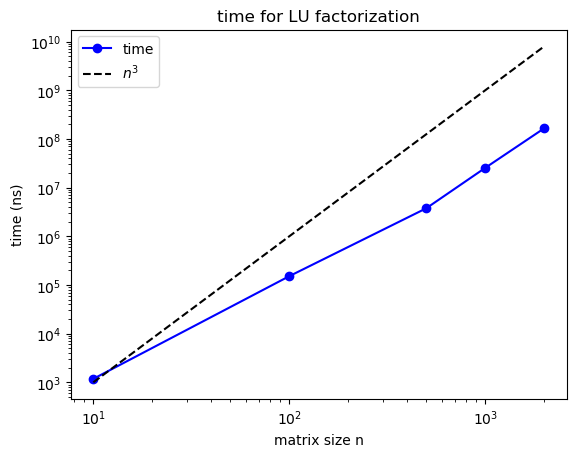

PyObject Text(0.5,1,'time for LU factorization')

In [7]:
using PyPlot
loglog(n, t*1e9, "bo-")
loglog(n, n.^3, "k--")
xlabel("matrix size n")
ylabel("time (ns)")
legend(["time", L"n^3"])
title("time for LU factorization")

It's pretty close!  For large $n$, you can see it starting to go parallel to the $n^3$ line.

Let's also look at the time to *solve* $LUx=b$ when we are *given* the LU factors, which we predict should grow $\sim n^2$:

In [4]:
ts = [@belapsed($(lufact(rand(n,n))) \ $(rand(n))) for n in n]

5-element Array{Float64,1}:
 3.40284e-7 
 0.00015732 
 0.000886265
 0.00191413 
 0.00571998 

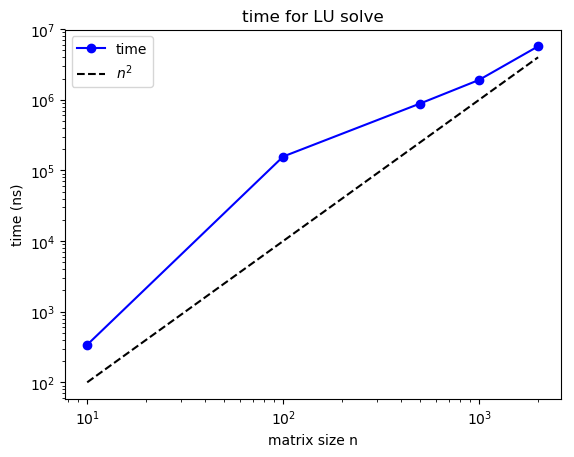

PyObject Text(0.5,1,'time for LU solve')

In [8]:
loglog(n, ts*1e9, "bo-")
loglog(n, n.^2, "k--")
xlabel("matrix size n")
ylabel("time (ns)")
legend(["time", L"n^2"])
title("time for LU solve")

Yup, it's pretty close to the $n^2$ growth!  The key point is that, unless you have many ($\gtrsim n$) right-hand sides, most of the effort is spent in Gaussian elimination (finding L and U), *not* in the back/forward-substitution to solve $LUx=b$.

If we believe this scaling, how long would it take for my laptop to solve a $10^6 \times 10^6$ system of equations?

In [9]:
t[end], n[end] # the last measured time and n for LU factorization

(0.165802911, 2000)

In [10]:
secs = t[end] * (1e6/n[end])^3 # this many seconds

2.0725363875e7

In [11]:
# convert to a human time period
Dates.canonicalize(Dates.CompoundPeriod(Dates.Second(round(Int,secs))))

34 weeks, 1 day, 21 hours, 2 minutes, 44 seconds

In fact, we **usually run out of memory before we run out of time:**

In [12]:
println((1e6)^2 * sizeof(Float64) / 2^30, " GiB for a 10⁶×10⁶ matrix")

7450.580596923828 GiB for a 10⁶×10⁶ matrix


In practice, people do *regularly* solve problems this large, and even larger, but they can do so because real matrices that big almost always have some **special structure** that allows you to solve them more quickly and store them more compactly.  For example, a common special structure is [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix): matrices whose entries are *mostly zero*.  We will learn some basic ways to take advantage of this later in 18.06, and sparse-matrix methods are covered more extensively in 18.335.